In [1]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document  # for proper document format

from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import BaseMessage
from pydantic import BaseModel , Field

from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser

from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph,END
from typing import List
import operator



In [2]:
import os
from dotenv import load_dotenv

os.environ['GOOGLE_API_KEY']=os.getenv("GOOGLE_API_KEY")
load_dotenv()

from langchain_google_genai import ChatGoogleGenerativeAI
llm_model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# 1. Create the embedding model
embeddings = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

# 2. Load your documents
documents = [Document(page_content="This is a tutorial on OpenAI embeddings")]

# 3. Create the vectorstore
vectorstore = Chroma.from_documents(documents, embedding=embeddings)

# 4. Get retriever to use in RAG
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})


In [7]:
class TopicSelectionParser(BaseModel):
    '''Parser for topic selection output.
    This parser extracts the selected topic and reasoning from the model's response.'''
    
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')


parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"description": "Parser for topic selection output.\\nThis parser extracts the selected topic and reasoning from the model\'s response.", "properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [8]:
def format_docs(docs):
    '''Format the documents for output.'''
    return "\n\n".join(doc.page_content for doc in docs)

In [9]:
class AgentState(TypedDict):
    ''' State of the agent, including messages and current question. '''
    messages: List[str]
    current_question: str


In [10]:
def Supervisor(state: AgentState):
    ''' Supervisor function to classify user questions into appropriate tools.
    Args:
        state (AgentState): The current state containing messages and the current question. '''


    messages = state.get("messages", [])
    if not messages:
        raise ValueError("No messages found in state for Supervisor.")

    question = messages[-1]
    print("📥 Supervisor received:", question)

    template = """
    You are an intelligent router. Your job is to classify the given user question into one of the following tools:
    - "LLM Call": For general or reasoning-based questions.
    - "RAG Call": For document-specific or internal knowledge base questions.
    - "DuckDuckGo Search": For questions requiring real-time or external information (e.g., weather, news, events).

    Based on the question, select the most appropriate tool and respond with the tool name using simple Python if-else logic.
    Respond ONLY in valid JSON format 

    Question: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | llm_model | parser
    response = chain.invoke({"question": question})

    print("🧭 Parsed response:", response)

    topic = response.get("Topic") if isinstance(response, dict) else getattr(response, "Topic", None)

    return {
        "messages": messages + [topic],
        "current_question": question
    }


In [11]:
def Router(state: AgentState):
    '''   Router function to determine the appropriate tool based on the current question.'''

    question = state["current_question"].lower()
    
    if any(x in question for x in ["real-time", "latest", "news", "today", "current"]):
        return "Web Crawler"
    elif "document" in question or "report" in question:
        return "RAG Call"
    else:
        return "LLM Call"


In [12]:
def LLM(state: AgentState):
    ''' Handles general questions using the LLM. '''
 
    llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
    
    question = state["current_question"]
    response = llm.invoke(question)

    return {
        "messages": state["messages"] + [response.content],
        "current_question": None
    }


In [13]:
def RAG(state:AgentState):
    ''' Function to handle RAG (Retrieval-Augmented Generation) calls.
    This function retrieves relevant documents based on the current question,'''
    
    print("-> RAG Call ->")
    
    question = state["current_question"]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm_model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {
        "messages": state["messages"] + [result],
        "current_question": None
    }

In [14]:
def WebCrawler(state: AgentState):
    import duckduckgo_search
    query = state["current_question"]
    results = duckduckgo_search.DDGS().text(query, max_results=1)
    answer = results[0]['body'] if results else "No relevant result found."
    
    return {
        "messages": state["messages"] + [answer],
        "current_question": None
    }


In [15]:
def validate_response(state: AgentState):
    response = state["messages"][-1]
    print("🔍 Validating response:", response)

    if response and isinstance(response, str) and len(response.split()) > 10:
        return {**state, "validation_passed": True}
    else:
        return {**state, "validation_passed": False}


In [16]:
def final_output(state: AgentState):
    print("✅ Final Output Node Reached")
    print("📦 Output Messages:", state.get("messages"))
    return state



In [17]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.set_entry_point("Supervisor")

# Nodes
workflow.add_node("Supervisor", Supervisor)
workflow.add_node("LLM", LLM)
workflow.add_node("RAG", RAG)
workflow.add_node("Web Crawler", WebCrawler)
workflow.add_node("Validate", validate_response)
workflow.add_node("Final Output", final_output)

# Router logic
workflow.add_conditional_edges(
    "Supervisor",
    Router,
    {
        "LLM Call": "LLM",
        "RAG Call": "RAG",
        "Web Crawler": "Web Crawler"
    }
)

# Post-processing validation
workflow.add_edge("LLM", "Validate")
workflow.add_edge("RAG", "Validate")
workflow.add_edge("Web Crawler", "Validate")

# Validation routing
def validation_router(state: dict):
    return "Final Output" if state.get("validation_passed") else "Supervisor"

workflow.add_conditional_edges(
    "Validate",
    validation_router,
    {
        "Final Output": "Final Output",
        "Supervisor": "Supervisor"
    }
)

workflow.add_edge("Final Output", END)

app = workflow.compile()


##### 🧠 LLM Call (general reasoning)

In [18]:
state = {
    "messages": ["What is the best OpenAI embedding model?"],
    "current_question": "What is the best OpenAI embedding model?"
}

result = app.invoke(state)
print("🎯 Final Result:", result["messages"][-1])


📥 Supervisor received: What is the best OpenAI embedding model?
🧭 Parsed response: Topic='LLM Call' Reasoning='The question requires general knowledge and opinion about OpenAI embedding models, which is best answered by a large language model.'
🔍 Validating response: There isn't a single "best" OpenAI embedding model, as the optimal choice depends heavily on your specific needs and priorities.  Different models offer different trade-offs between accuracy, speed, and cost.  OpenAI's offerings evolve, so what's considered best might change over time.

However, as of October 26, 2023,  `text-embedding-ada-002` is often cited as a good general-purpose choice. It strikes a reasonable balance between cost-effectiveness and accuracy for many applications.

Here's a breakdown of considerations to help you choose:

* **`text-embedding-ada-002`:** This is the most commonly recommended model. It's a good all-arounder, offering a balance of speed, cost, and accuracy.  It's often the default choice

 ##### RAG Call (internal/doc-based)

In [19]:
state = {
    "messages": ["Can you summarize this document about OpenAI embeddings?"],
    "current_question": "Can you summarize this document about OpenAI embeddings?"
}

In [20]:
result = app.invoke(state)
print("🎯 Final Result:", result["messages"])

📥 Supervisor received: Can you summarize this document about OpenAI embeddings?
🧭 Parsed response: Topic='RAG Call' Reasoning='The question explicitly mentions summarizing a provided document, indicating the need to access and process the content of that document. This is a task best suited for a RAG (Retrieval Augmented Generation) system.'
-> RAG Call ->
🔍 Validating response: This document is a tutorial explaining OpenAI embeddings.  It teaches how to use them.  No further details on the tutorial's specific content are provided.
✅ Final Output Node Reached
📦 Output Messages: ['Can you summarize this document about OpenAI embeddings?', 'RAG Call', "This document is a tutorial explaining OpenAI embeddings.  It teaches how to use them.  No further details on the tutorial's specific content are provided."]
🎯 Final Result: ['Can you summarize this document about OpenAI embeddings?', 'RAG Call', "This document is a tutorial explaining OpenAI embeddings.  It teaches how to use them.  No fu

##### DuckDuckGo Search (real-time info) 

In [21]:
state = {
    "messages": ["What is the current weather in Delhi?"],
    "current_question": "What is the current weather in Delhi?"
}

In [22]:
result = app.invoke(state)
print("🎯 Final Result:", result["messages"][-1])

📥 Supervisor received: What is the current weather in Delhi?
🧭 Parsed response: Topic='DuckDuckGo Search' Reasoning='The question requires real-time information about the current weather in Delhi, which necessitates an external search engine like DuckDuckGo.'
🔍 Validating response: Current weather in Delhi, Delhi, India. Check current conditions in Delhi, Delhi, India with radar, hourly, and more.
✅ Final Output Node Reached
📦 Output Messages: ['What is the current weather in Delhi?', 'DuckDuckGo Search', 'Current weather in Delhi, Delhi, India. Check current conditions in Delhi, Delhi, India with radar, hourly, and more.']
🎯 Final Result: Current weather in Delhi, Delhi, India. Check current conditions in Delhi, Delhi, India with radar, hourly, and more.


In [25]:
# To test Web Crawler
state_web = {
    "messages": ["India latest flight crash news?"],
    "current_question": "In India latest flight cras news?"
}
result_web = app.invoke(state_web)
print("🌐 Web Crawler Result:", result_web["messages"][-1])

📥 Supervisor received: India latest flight crash news?
🧭 Parsed response: Topic='DuckDuckGo Search' Reasoning='The question asks for real-time information (latest news) which requires accessing an external information source like DuckDuckGo Search.'
🔍 Validating response: Ahmedabad Plane Crash Updates:Investigators recovered the black box of the ill-fated Air India Boeing 787-8 Dreamliner (AI171) from the rooftop of a medical college hostel, a day after it crashed in Ahmedabad, killing 241 of the 242 on board. The Aircraft Accident Investigation Bureau confirmed the retrieval of the Digital Flight Data Recorder, key to understanding the crash.
✅ Final Output Node Reached
📦 Output Messages: ['India latest flight crash news?', 'DuckDuckGo Search', 'Ahmedabad Plane Crash Updates:Investigators recovered the black box of the ill-fated Air India Boeing 787-8 Dreamliner (AI171) from the rooftop of a medical college hostel, a day after it crashed in Ahmedabad, killing 241 of the 242 on board. 

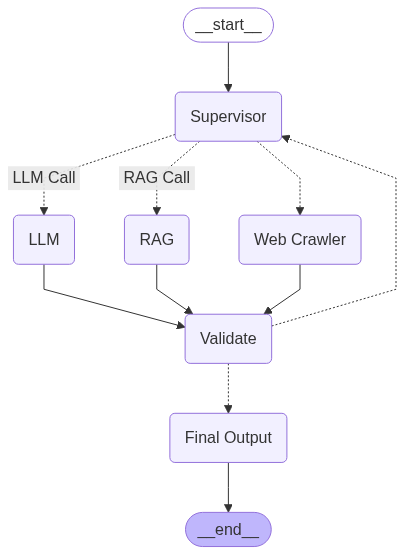

In [26]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))